# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка.

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время.

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов.

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [272]:
import numpy as np  # для матричных вычислений
import pandas as pd  # для анализа и предобработки данных
import matplotlib.pyplot as plt  # для визуализации
import seaborn as sns  # для визуализации

# Импорт библиотек для машинного обучения
from sklearn.model_selection import GridSearchCV  # для поиска по сетке
from sklearn import linear_model  # для линейных моделей
from sklearn import metrics  # для метрик оценки моделей
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler  # для масштабирования данных
from sklearn.feature_selection import chi2, f_classif  # для отбора признаков
from sklearn import model_selection  # для сплитования выборки
from sklearn import preprocessing  # для предобработки данных
from scipy import stats  # для статистических функций

# Настройка предупреждений
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # игнорировать предупреждения FutureWarning

# Импорт библиотек для работы с данными
import zipfile  # для работы с zip-архивами
import requests  # для выполнения HTTP-запросов

# Настройка визуализации
%matplotlib inline
sns.set_theme('notebook')  # установка темы для seaborn
sns.set_palette("RdPu")  # установка цветовой палитры для seaborn

# Подготовим некоторые функции, которые будем использовать в дальнейшем

In [267]:
pd.set_option('display.float_format', '{:.2f}'.format) #для удобного отображения вещественных чисел

In [268]:
def test_manna(data, col, alpha=0.05):
  """
  Проводит непараметрический тест Манна-Уитни (U-тест).

  :data: Входные данные датафрейм пандас
  :col: Признак ля проведения теста
  :return: Результат теста и вывод
  """
  group1 = data[data['Exited'] == 0][col]
  group2 = data[data['Exited'] == 1][col]

  # Проведение теста Манна-Уитни
  stat, p_value = stats.mannwhitneyu(group1, group2)

  if p_value < alpha:
      print(f"p-значение: {p_value:.5f}. Признак {col} статистически значим для Exited.")
  else:
      print(f"p-значение: {p_value:.5f}. Признак {col} не статистически значим для Exited.")

In [269]:
def check_normality(data, alpha=0.05):
    """
    Проверяет нормальность распределения данных с помощью теста Шапиро-Уилка.

    :data: Входные данные (одномерный массив или Series)
    :alpha: Уровень значимости (по умолчанию 0.05)
    :return: Результат теста и вывод о нормальности
    """
    # Выполнение теста Шапиро-Уилка
    stat, p_value = stats.shapiro(data)

    # Проверка p-значения
    if p_value > alpha:
        return "распределение нормально"
    else:
        return "распределение не нормально"


In [270]:
def read_zip(url: str, zip_file_name: str) -> pd.DataFrame:
    """
    Функция скачивает ZIP-файл по указанной ссылке, извлекает CSV-файл из архива
    и читает его с помощью pandas.

    Аргументы:
    url (str): Ссылка на ZIP-архив, содержащий CSV-файл.
    zip_file_name (str): Название, с которым ZIP-файл будет сохранен локально.

    Возвращает:
    pandas.DataFrame: Данные из CSV-файла в формате DataFrame.
    """
    response = requests.get(url)

    # Сохраняем ZIP-файл локально
    with open(zip_file_name, 'wb') as file:
        file.write(response.content)

    # Открываем ZIP-архив для чтения
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        file_name = zip_ref.namelist()[0]
        df = pd.read_csv(zip_ref.open(file_name))

    return df

Итак, прочитаем нашу таблицу:

In [273]:
url = 'https://lms-cdn.skillfactory.ru/assets/courseware/v1/1e9752711f76fc98e2e431c7c65bb420/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ML-3_churn.zip'
zip_file_name = 'ML-3_churn.zip'
df = read_zip(url, zip_file_name)

# Выводим первые несколько строк загруженных данных
df.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [274]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,2500.75,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


In [275]:
df.select_dtypes(include=['object']).describe()


,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


* В нашем распоряжении находятся данные о 10,000 пользователей.
* В этом наборе данных преобладают мужчины. Возраст пользователей варьируется от 18 до 92 лет.
* Большинство клиентов происходят из Франции.
* Максимальное количество банковских продуктов, которыми могут владеть клиенты, составляет 4.
* Длительность клиентского обслуживания варьируется максимум от 0 до 10 лет.
* Заработная плата клиентов колеблется в пределах от 11 до 200,000.
* Баланс пользователей варьируется от 0 до 251,000.
* В данных отсутствуют пропуски.

## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные.

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

**Посмотрим как распределяется в данных целевой признак**

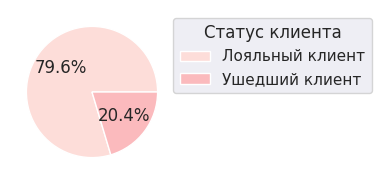

In [276]:
dict_replacement = {
                    0: 'Лояльный клиент',
                    1: 'Ушедший клиент'
                    }
df['Status'] = df['Exited'].map(dict_replacement)
clients = df['Status'].value_counts()
fig, axes = plt.subplots(figsize=(7, 2))

plt.pie(
    clients,
    autopct='%.1f%%',
    )
axes.legend(
            clients.index,
            title='Статус клиента',
            loc='upper left',
            bbox_to_anchor=(0.95, 1)
            );
plt.tight_layout()
df = df.drop(['Status'], axis=1)

Данные не сбалансированы. Доля лояльных клиентов в данных значительно выше,чем доля ушедших.

**Смотрим как распределяются данные в каждом признаке**

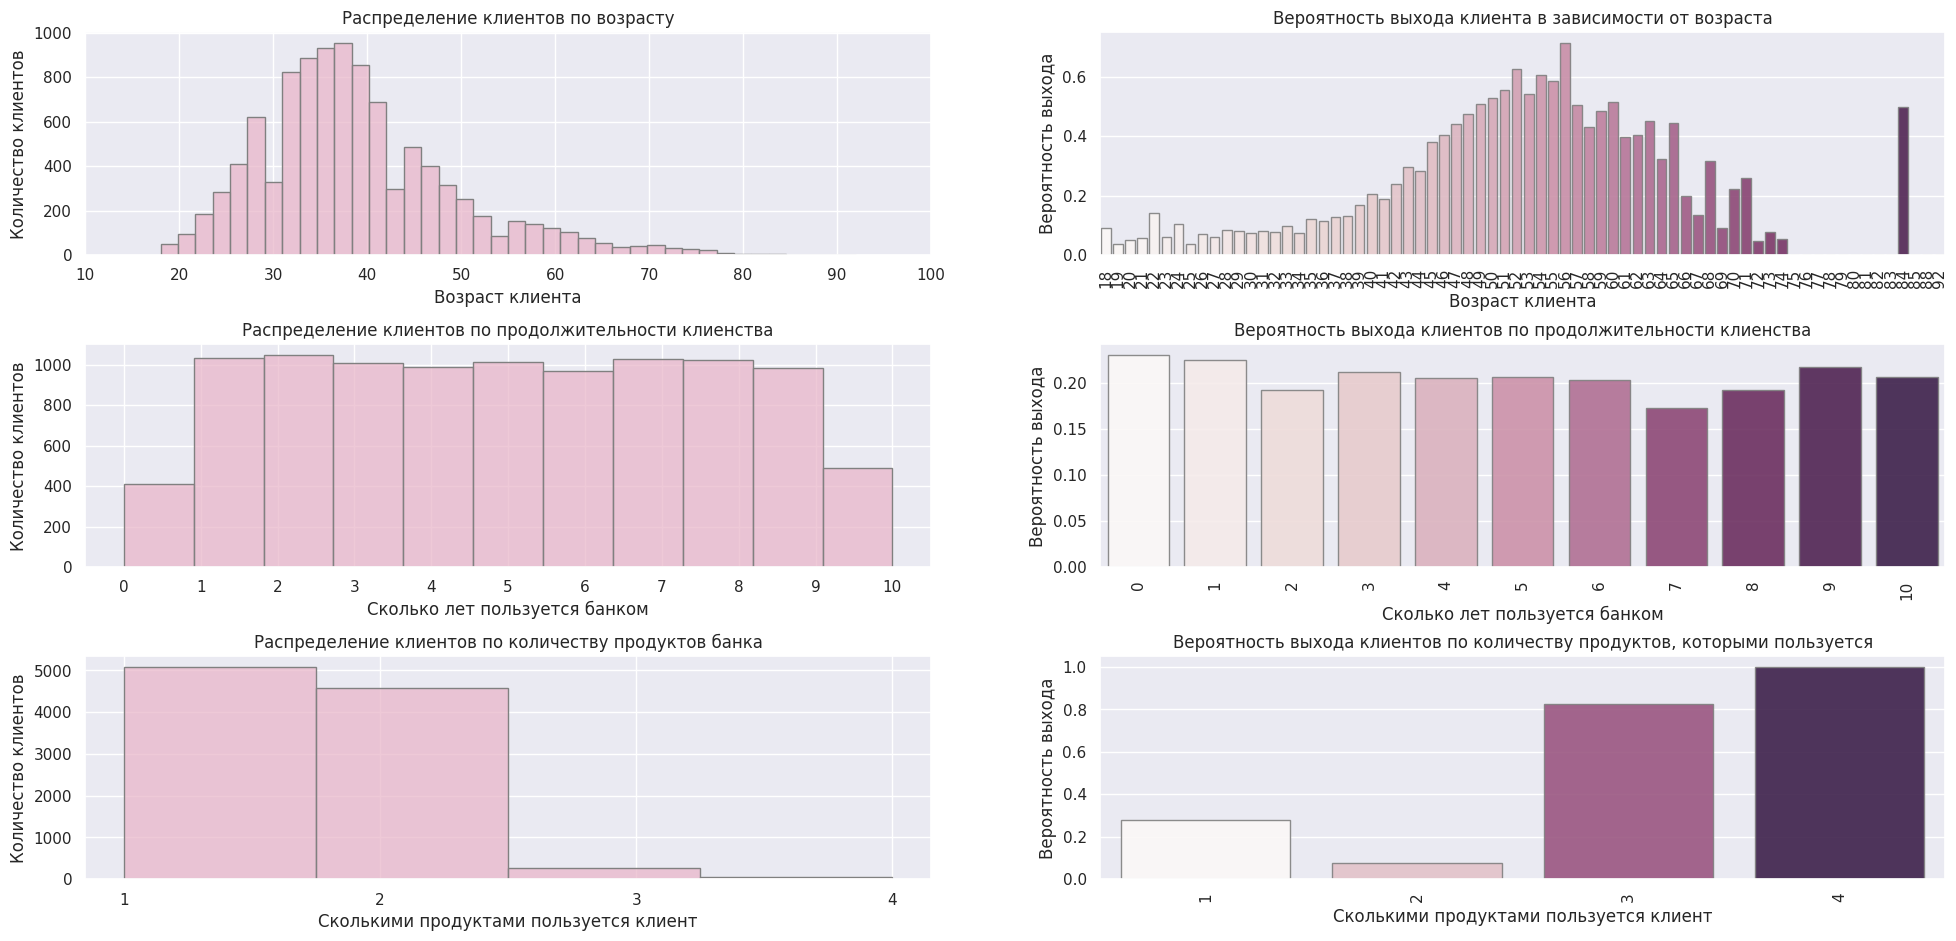

In [277]:
def plot_histogram(ax, data, x_col, color, title, xlabel, bins_, kde=False, element="bars", xticks=False):
    sns.histplot(data, x=x_col, color=color, edgecolor='grey', bins=bins_, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Количество клиентов')
    if not xticks:
      ax.set_xticks(ax.get_xticks())
    else:
      ax.set_xticks(xticks)
def plot_bar(ax, data, x_col, title, xlabel):
    group_df = df.groupby(x_col, observed=True)['Exited'].agg(['mean']).reset_index()

    sns.barplot(
        group_df,
        x=f'{x_col}',
        y='mean',
        hue=f'{x_col}',
        palette='RdPu',
        saturation=0.4,
        alpha=0.9,
        edgecolor='grey',
        legend=False,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Вероятность выхода')
    ax.tick_params(axis='x', rotation=90)

fig, axes = plt.subplots(3, 2, figsize=(24, 11))
plt.subplots_adjust(hspace=0.4)


# График 1: Распределение по возрасту
plot_histogram(axes[0][0], df, 'Age', '#e9b7ca',
               'Распределение клиентов по возрасту',
               'Возраст клиента',
               bins_=40
               )

plot_bar(axes[0][1], df, 'Age',
         title='Вероятность выхода клиента в зависимости от возраста',
         xlabel='Возраст клиента')

# График 2: Распределение по продолжительности клиенства
plot_histogram(axes[1][0], df, 'Tenure', '#e9b7ca',
               'Распределение клиентов по продолжительности клиенства',
               'Сколько лет пользуется банком',
               bins_=11,
               xticks=range(0,11)
               )

plot_bar(axes[1][1], df, 'Tenure',
         title='Вероятность выхода клиентов по продолжительности клиенства',
         xlabel='Сколько лет пользуется банком')

# График 3: Распределение по количеству продуктов
plot_histogram(axes[2][0], df, 'NumOfProducts', '#e9b7ca',
              'Распределение клиентов по количеству продуктов банка',
               'Сколькими продуктами пользуется клиент',
               bins_=4,
               xticks=range(1,5)
               )

plot_bar(axes[2][1], df, 'NumOfProducts',
         title='Вероятность выхода клиентов по количеству продуктов, которыми пользуется',
         xlabel='Сколькими продуктами пользуется клиент')


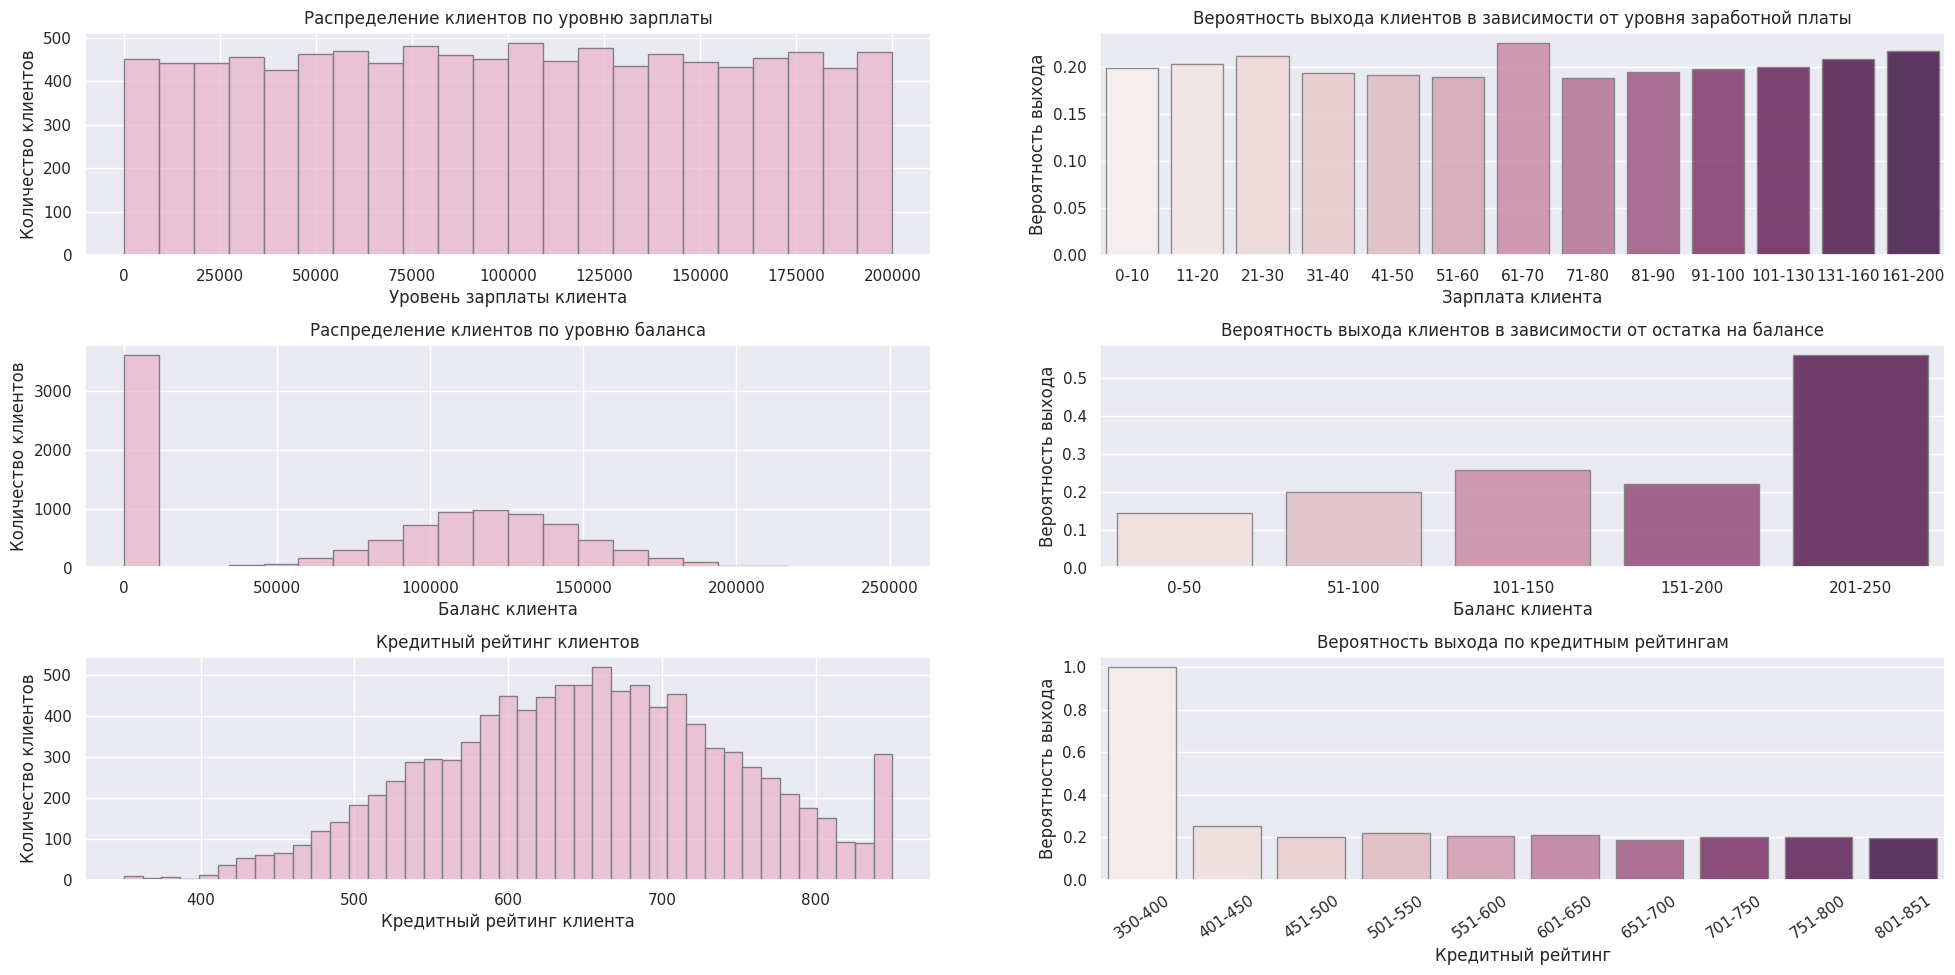

In [278]:
def plot_histogram(ax, data, x_col, color, title, xlabel, ylabel):
    sns.histplot(data, x=x_col, color=color, edgecolor='grey', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot_bar(ax, data, x_col, y_col, bins, labels, title, xlabel, ylabel, divide_by_thousand=True):
    df = data[[x_col, y_col]].copy()
    if divide_by_thousand:
      df[x_col] = df[x_col] // 1000
    df[f'{x_col}Bins'] = pd.cut(df[x_col], bins=bins, labels=labels, right=False)
    group_df = df.groupby(f'{x_col}Bins', observed=True)[y_col].agg(['mean']).reset_index()

    sns.barplot(
        group_df,
        x=f'{x_col}Bins',
        y='mean',
        hue=f'{x_col}Bins',
        palette='RdPu',
        saturation=0.4,
        alpha=0.9,
        edgecolor='grey',
        legend=False,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

fig, axes = plt.subplots(3, 2, figsize=(24, 11))
plt.subplots_adjust(hspace=0.4)

# График 1: Распределение по зарплате
plot_histogram(axes[0][0], df, 'EstimatedSalary', '#e9b7ca',
               'Распределение клиентов по уровню зарплаты',
               'Уровень зарплаты клиента',
               'Количество клиентов')

plot_bar(axes[0][1], df, 'EstimatedSalary', 'Exited',
         bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 130, 160, 200],
         labels=['0-10', '11-20', '21-30', '31-40', '41-50',
                 '51-60', '61-70', '71-80', '81-90', '91-100',
                 '101-130', '131-160', '161-200'],
         title='Вероятность выхода клиентов в зависимости от уровня заработной платы',
         xlabel='Зарплата клиента',
         ylabel='Вероятность выхода')

# График 2: Распределение по балансу
plot_histogram(axes[1][0], df, 'Balance', '#e9b7ca',
               'Распределение клиентов по уровню баланса',
               'Баланс клиента',
               'Количество клиентов')

plot_bar(axes[1][1], df, 'Balance', 'Exited',
         bins=[0, 50, 100, 150, 200, 251],
         labels=['0-50', '51-100', '101-150', '151-200', '201-250'],
         title='Вероятность выхода клиентов в зависимости от остатка на балансе',
         xlabel='Баланс клиента',
         ylabel='Вероятность выхода')

# График 3: Распределение по кредитному рейтингу
plot_histogram(axes[2][0], df, 'CreditScore', '#e9b7ca',
               'Кредитный рейтинг клиентов',
               'Кредитный рейтинг клиента',
               'Количество клиентов')

# Вероятность ухода клиента в зависимости от кредитного рейтинга
plot_bar(axes[2][1], df, 'CreditScore', 'Exited',
         bins=[350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 851],
         labels=['350-400', '401-450', '451-500', '501-550', '551-600',
          '601-650', '651-700', '701-750', '751-800', '801-851'],
         title='Вероятность выхода по кредитным рейтингам',
         xlabel='Кредитный рейтинг',
         ylabel='Вероятность выхода',
         divide_by_thousand=False)
plt.xticks(rotation=35)
plt.show()

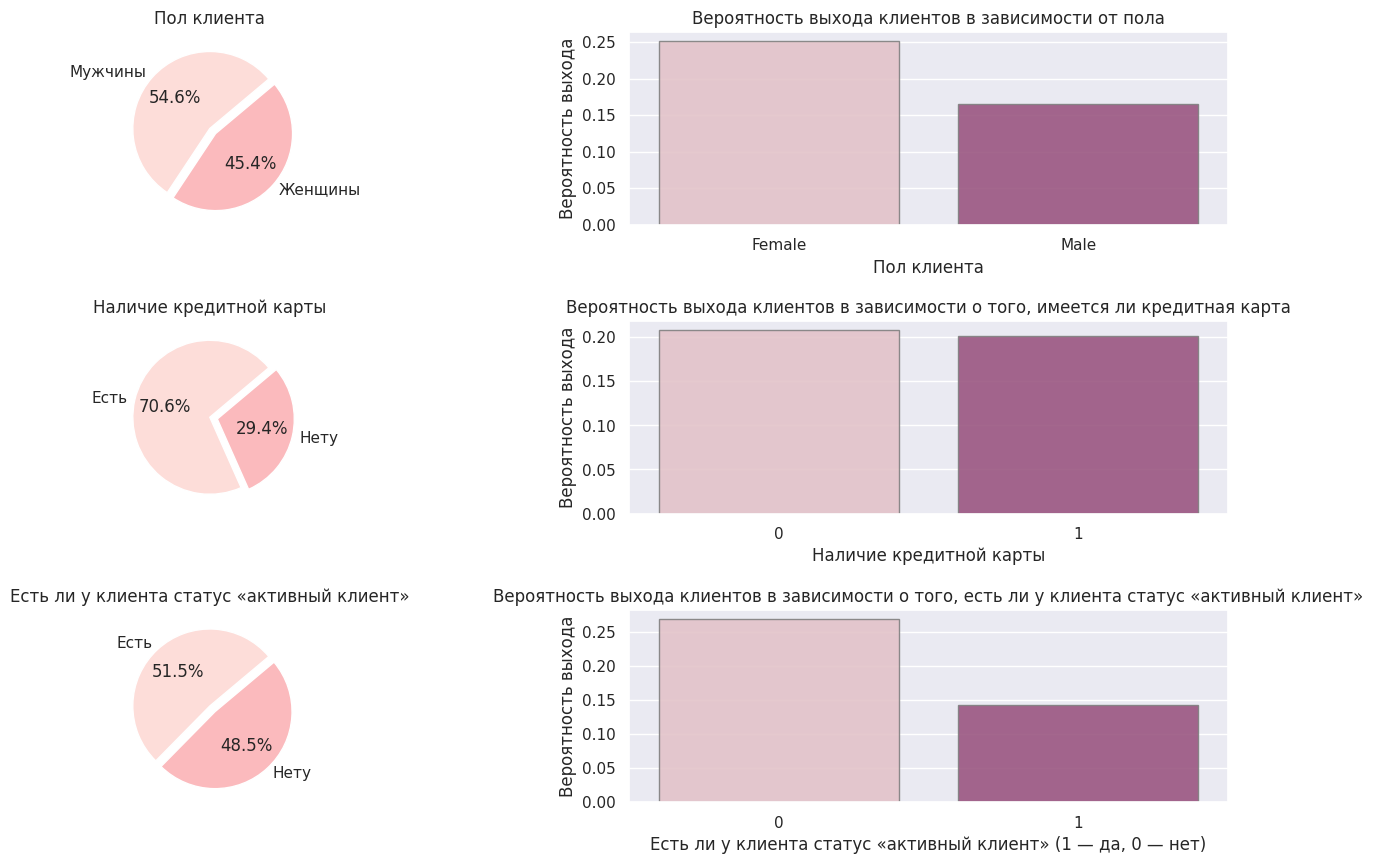

<Figure size 640x480 with 0 Axes>

In [279]:
def plot_pie(ax, data, x_col, title, labels_):
    ax.pie(
      data[x_col].value_counts(),
      explode=(0, 0.1),
      startangle=40,
      labels = labels_,
      autopct='%.1f%%')
    ax.set_title(title)

def plot_bar(ax, data, x_col, title, xlabel):
    group_df = data.groupby(x_col, observed=True)['Exited'].agg(['mean']).reset_index()

    sns.barplot(
        group_df,
        x=x_col,
        y='mean',
        hue=x_col,
        palette='RdPu',
        saturation=0.4,
        alpha=0.9,
        edgecolor='grey',
        legend=False,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Вероятность выхода')


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(17,10))
plt.subplots_adjust(hspace=0.5)

# График 1: Распределение по полу клиента.
plot_pie(axes[0][0], df, 'Gender', 'Пол клиента', ['Мужчины', 'Женщины'])

# Вероятность выхода клиентов в зависимости от пола
plot_bar(
    axes[0][1],
    df,
    x_col='Gender',
    title='Вероятность выхода клиентов в зависимости от пола',
    xlabel='Пол клиента')

# График 2: Распределение по наличию кредитной карты.
plot_pie(axes[1][0], df, 'HasCrCard', 'Наличие кредитной карты', ['Есть', 'Нету'])

# Вероятность выхода клиентов в зависимости о того, имеется ли кредитная карта
plot_bar(
    axes[1][1],
    df,
    x_col='HasCrCard',
    title='Вероятность выхода клиентов в зависимости о того, имеется ли кредитная карта',
    xlabel='Наличие кредитной карты')

# График 3: Распределение по наличию у клиента статуса "активный клиент".
plot_pie(axes[2][0], df, 'IsActiveMember', 'Eсть ли у клиента статус «активный клиент»', ['Есть', 'Нету'])

# Вероятность выхода клиентов в зависимости о того, имеется ли кредитная карта
plot_bar(
    axes[2][1],
    df,
    x_col='IsActiveMember',
    title='Вероятность выхода клиентов в зависимости о того, есть ли у клиента статус «активный клиент»',
    xlabel='Eсть ли у клиента статус «активный клиент» (1 — да, 0 — нет)')

plt.show();
plt.tight_layout();

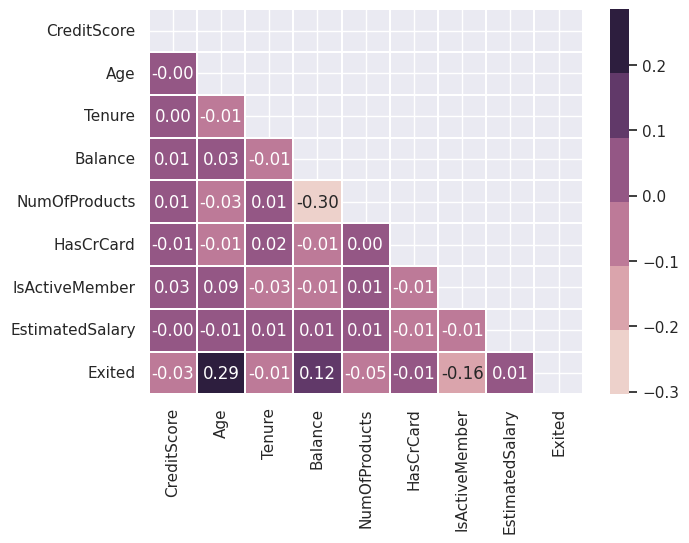

In [280]:
fig_, ax_ = plt.subplots(figsize=(7, 5))
corr = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
           'IsActiveMember', 'EstimatedSalary', 'Exited']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,
            annot=True,
            linewidths=0.1,
            ax=ax_,
            cmap=sns.cubehelix_palette(),
            mask=mask,
            fmt='.2f')
plt.show();

>**На текущем этапе анализа можно сделать следующие выводы:**
*   Клиенты в возрасте от 45 до 66 лет наиболее подвержены риску ухода.
*   Оптимальное количество банковских услуг для клиента составляет 2. С увеличением или уменьшением этого количества вероятность ухода повышается.
*   Среди ушедших клиентов реже всего встречаются те, кто пользуется услугами банка от 2 до 8 лет.
*   Уровень заработной платы практически не оказывает влияния на вероятность ухода клиента в другой банк.
*   Лояльные клиенты чаще всего имеют минимальный баланс денежных средств.
*   Кредитный рейтинг не оказывает значительного влияния на лояльность клиентов. Исключением являются клиенты с очень низким кредитным рейтингом, у которых наблюдается повышенная вероятность ухода.
*   Количество мужчин и женщин в выборке примерно одинаково, однако женщины более склонны к уходу из банка.
*   Наличие кредитной карты у клиента практически не влияет на вероятность его ухода.


В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [281]:
df = df[df['Geography'] == 'Germany']
df.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [283]:
df = df.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [284]:
df.isnull().sum()

,0
CreditScore,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0
Exited,0


Проверим, что в наших данных нет дубликатов:

In [285]:
df[df.duplicated()].sum()

,0
CreditScore,0
Gender,0
Age,0
Tenure,0
Balance,0.00
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0.00
Exited,0


### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных.

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**):
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [293]:
# Создание новых признаков
df['BalanceSalaryRatio'] = df['Balance'] / df['EstimatedSalary']
df['TenureByAge'] = df['Tenure'] / df['Age']
df['CreditScoreGivenAge'] = df['CreditScore'] / df['Age']

# Извлечение и перекодировка категориальных признаков в бинарный формат
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Используем pd.get_dummies() для всех категориальных признаков и NumOfProducts с префиксом
df_encoded = pd.get_dummies(df[categorical_cols].astype(str), drop_first=True).astype('int')
df_products_encoded = pd.get_dummies(df['NumOfProducts'], prefix='NumOfProducts', drop_first=True).astype('int')

# Объединяем закодированные данные с основным DataFrame и удаляем оригинальные категориальные колонки
df_final = pd.concat([df.drop(categorical_cols, axis=1), df_encoded, df_products_encoded], axis=1)

In [295]:
df_final.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
count,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00,2509.00
mean,651.45,39.77,5.01,119730.12,1.52,0.71,0.50,101113.44,0.32,9.02,0.13,17.53,0.52,0.41,0.04,0.01
std,98.17,10.52,2.94,27022.01,0.62,0.45,0.50,58263.01,0.47,214.29,0.09,5.35,0.50,0.49,0.19,0.10
min,350.00,18.00,0.00,27288.43,1.00,0.00,0.00,11.58,0.00,0.19,0.00,6.11,0.00,0.00,0.00,0.00
25%,584.00,32.00,2.00,102800.72,1.00,0.00,0.00,51016.02,0.00,0.78,0.06,13.69,0.00,0.00,0.00,0.00
50%,651.00,38.00,5.00,119703.10,1.00,1.00,0.00,102397.22,0.00,1.20,0.12,16.86,1.00,0.00,0.00,0.00
75%,722.00,45.00,8.00,137560.38,2.00,1.00,1.00,151083.80,1.00,2.40,0.20,20.85,1.00,1.00,0.00,0.00
max,850.00,84.00,10.00,214346.96,4.00,1.00,1.00,199970.74,1.00,10614.66,0.50,46.39,1.00,1.00,1.00,1.00


In [296]:
for col in df_final.columns[-7:-4]:
  correlation = df_final[[col, 'Exited']].corr()
  print(f'Корреляция между {col} и Exited = {round(correlation["Exited"].iloc[0], 2)}')
print()
for col in df_final.columns[-7:-4]:
  # Проверка нормальности
  result = check_normality(df_final[col])
  print(f'В признаке {col} - {result}')
print()
for col in df_final.columns[-7:-4]:
  # Проверка статистической значимости
  test_manna(df_final, col)

Корреляция между BalanceSalaryRatio и Exited = 0.03
Корреляция между TenureByAge и Exited = -0.13
Корреляция между CreditScoreGivenAge и Exited = -0.3

В признаке BalanceSalaryRatio - распределение не нормально
В признаке TenureByAge - распределение не нормально
В признаке CreditScoreGivenAge - распределение не нормально

p-значение: 0.04201. Признак BalanceSalaryRatio статистически значим для Exited.
p-значение: 0.00000. Признак TenureByAge статистически значим для Exited.
p-значение: 0.00000. Признак CreditScoreGivenAge статистически значим для Exited.


Обработаем возраст, сделав его бинарным признаком

In [297]:
df_final['AgeBetween18And41'] = (df_final['Age'] <= 41).astype('int')
df_final['AgeBetween42And47']= ((df_final['Age'] > 41) & (df_final['Age'] <= 47)).astype('int')
df_final['AgeBetween48And65']= ((df_final['Age'] > 47) & (df_final['Age'] <= 65)).astype('int')
df_final['AgeMore65'] = (df_final['Age'] > 65).astype('int')

# Перед тем как приступать к обучению нужно проверить корреляции и важность признаков.

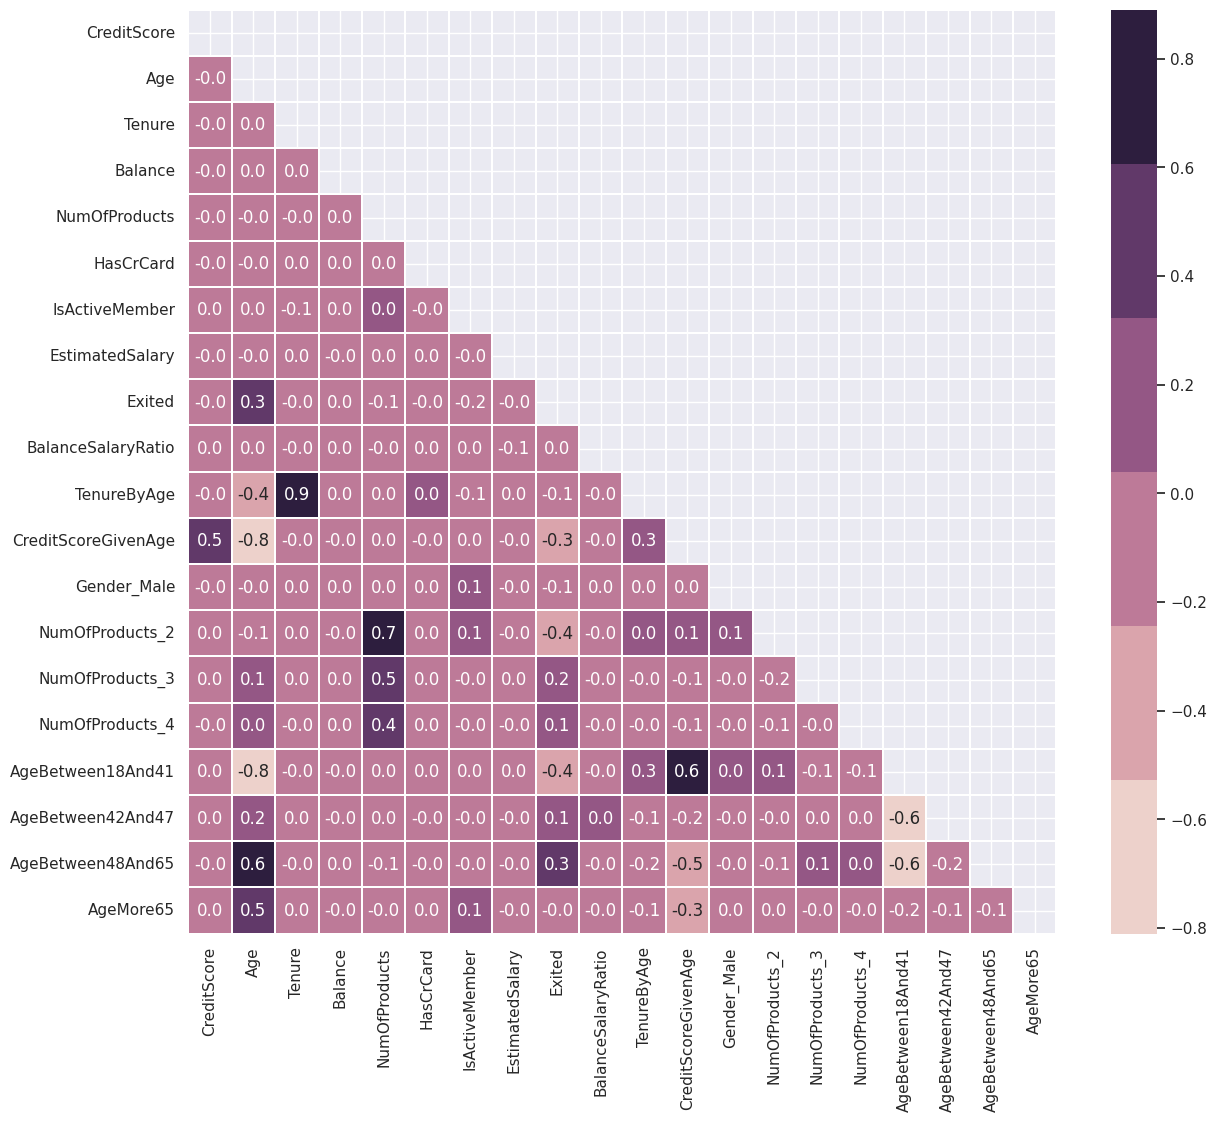

In [298]:
fig_, ax_ = plt.subplots(figsize=(14, 12))
corr = df_final.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,
            annot=True,
            linewidths=0.1,
            ax=ax_,
            cmap=sns.cubehelix_palette(),
            mask=mask,
            fmt='.1f')
plt.show();

У следующих признаков очень сильная корреляция, их необходимо удалить из данных.

In [299]:
df_final = df_final.drop(['Age', 'Tenure', 'NumOfProducts'], axis=1)

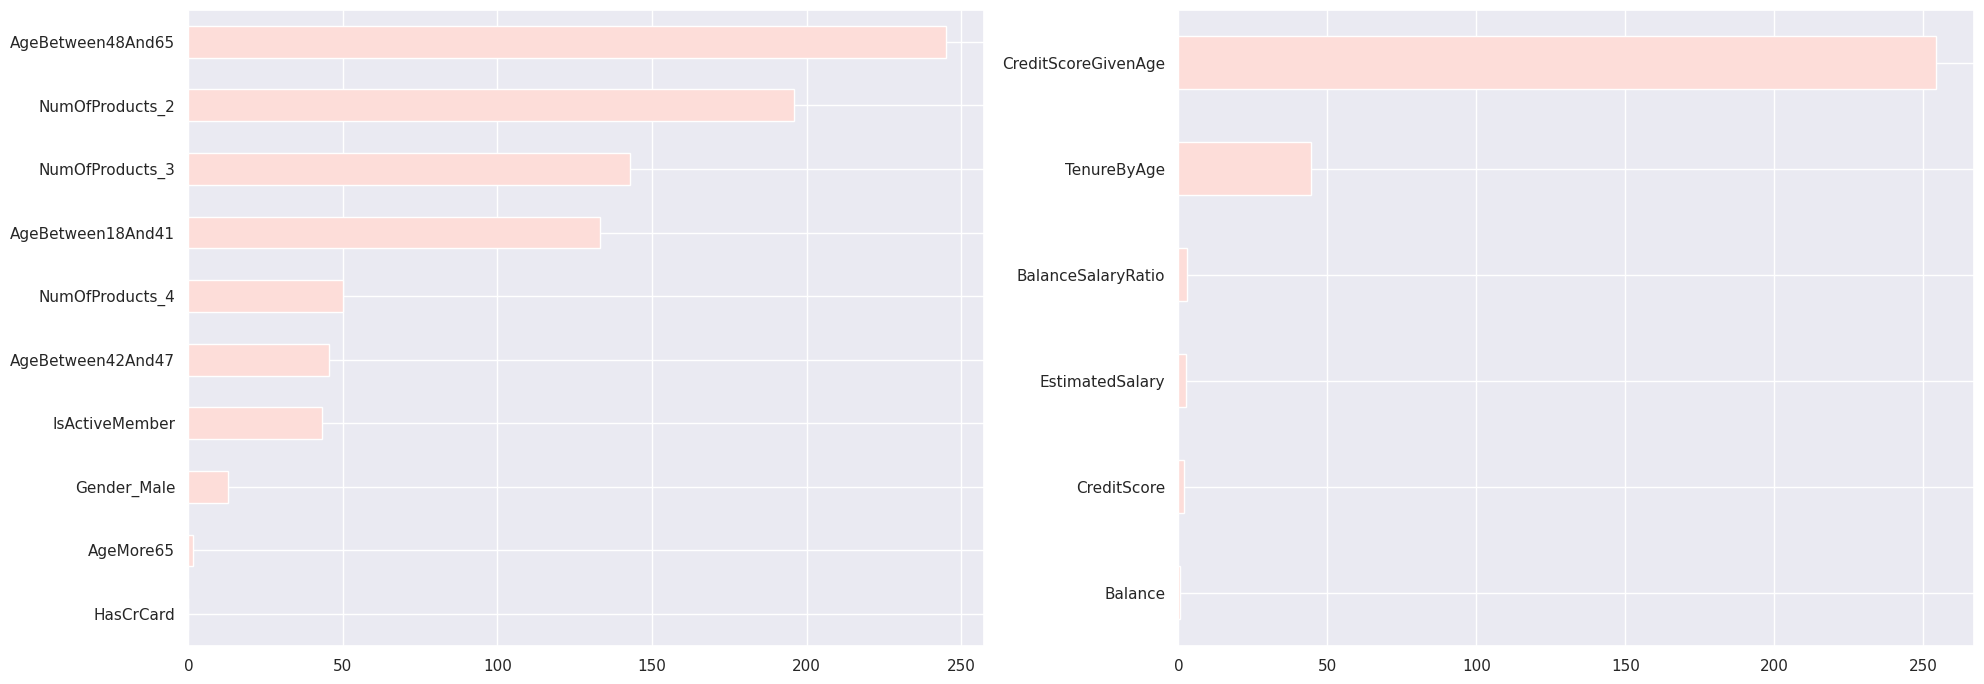

In [300]:
cat_cols = ['HasCrCard', 'IsActiveMember', 'Gender_Male', 'NumOfProducts_2', 'NumOfProducts_3',
            'NumOfProducts_4', 'AgeBetween18And41', 'AgeBetween42And47', 'AgeBetween48And65',
            'AgeMore65']
num_cols = ['CreditScore', 'Balance', 'EstimatedSalary',  'BalanceSalaryRatio', 'TenureByAge', 'CreditScoreGivenAge']
y = df_final['Exited']

imp_cat = pd.Series(chi2(df_final[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)

fig5, ax5 = plt.subplots(1, 2, figsize=(20, 7))
imp_cat.plot(kind = 'barh', ax=ax5[0]);

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(df_final[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)

imp_num.plot(kind = 'barh', ax=ax5[1])
plt.tight_layout();

In [301]:
df_final = df_final.drop(['HasCrCard', 'Balance'], axis=1)

Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет).

In [302]:
X = df_final.drop("Exited", axis=1)
y = df_final["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [303]:
y.value_counts(normalize=True)

,proportion
Exited,
0,0.68
1,0.32


Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**.

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y.

Выполним разбиение, установив значение параметра `random_state` на 0:


In [304]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y,
    stratify=y,
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 14)
Test shape: (628, 14)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [305]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


,proportion
Exited,
0,0.68
1,0.32




Test :


,proportion
Exited,
0,0.68
1,0.32


Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**):
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

>Так как в непрерывных признаках наблюдаются выбросы, а также данные не имеют нормального распределения, то лучшим выбором будет **RobustScaler.**
Он масштабирует данные с использованием медианы и межквартильного размаха (IQR). Это делает его более устойчивым к выбросам и лучше работает с данными, которые имеют нессиметричное распределение.
>
>Но проведя обучение с различными скейлерами, лучшим решением является всетаки StandardScaler.


In [306]:
# Инициализация StandardScaler
scaler = StandardScaler()

# Список столбцов, которые нужно нормализовать
columns_to_scale = ['CreditScore', 'EstimatedSalary', 'BalanceSalaryRatio', 'TenureByAge', 'CreditScoreGivenAge']

# Подгоняем параметры стандартизатора (вычисляем min и max)
scaler.fit(X_train[columns_to_scale])

# Обучение скейлера на тренировочной выборке и трансформация данных
X_train_scaled = X_train.copy()  # Создаем копию данных для избежания изменения оригинала
X_test_scaled = X_test.copy()

# Нормализуем только выбранные столбцы
X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться.

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**):
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> В данной задаче, где необходимо предсказывать отток клиентов и минимизировать как ложноположительные, так и ложноотрицательные срабатывания модели, наиболее подходящей метрикой будет F1-мерка.
>
>* F1-мерка является гармоническим средним между точностью (precision) и полнотой (recall). Это важно в нашем случае, так как мы хотим минимизировать как ложноположительные, так и ложноотрицательные срабатывания. Высокая точность означает, что среди предсказанных "оттоков" действительно много клиентов, которые уйдут, а высокая полнота означает, что мы выявляем большинство клиентов, которые действительно собираются уйти.
>
>* У нас в данных имеются нсбалансированные классы и  F1-мерка помогает лучше оценить качество модели в таких условиях, чем простая точность, которая может вводить в заблуждение.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках.

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**):
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [307]:
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred = log_reg.predict(X_train_scaled)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred)))
#Делаем предсказание класса
y_pred_test = log_reg.predict(X_test_scaled)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 0.66
F1 score: 0.63


> Уже неплохой результат. Метрика больше 0.6 и на тестовой и тренировочной метрики имеют близкие значения. У модели нет сильного переоучения.
Попробуем ее еще улучшить, подобрав лучшие парметры с помощью  Grid Search.

In [308]:
# Определение параметров для Grid Search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Регуляризация
    'penalty': ['l1', 'l2'], # Тип регуляризации
    'solver': ['liblinear', 'saga'],  # Алгоритмы оптимизации
    'class_weight': [None, 'balanced']  # Взвешивание классов
}

# Создание объекта логистической регрессии
log_reg_grid_search = linear_model.LogisticRegression(random_state=42, max_iter=1000)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=log_reg_grid_search, param_grid=param_grid,
                           scoring='f1', cv=5, n_jobs=-1, error_score='raise')

# Обучение модели
grid_search.fit(X_train_scaled, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Делаем предсказание на тестовой выборке с лучшей моделью
best_model_log_reg = grid_search.best_estimator_
y_pred_train = best_model_log_reg.predict(X_train_scaled)
y_pred_test = best_model_log_reg.predict(X_test_scaled)

# Рассчитываем F1-меру для тренировочной выборки лучшей модели
print('F1 score с лучшей моделью: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))

# Рассчитываем F1-меру для тестовой выборки лучшей модели
print('F1 score с лучшей моделью: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Лучшие параметры: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
F1 score с лучшей моделью: 0.68
F1 score с лучшей моделью: 0.68


> С подбором параметров удалось повысить метрику до 0.68 на тестовой выборки.
Переобучения сейчас не наблюдается, так как метрики на тренировочных и тестовых данных равны.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**):
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [309]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scaled)

#Создаём объект класса LogisticRegression
log_reg_poly = linear_model.LogisticRegression(random_state=42, max_iter=1000)
#Обучаем модель
log_reg_poly.fit(X_train_poly, y_train)

#Делаем предсказание класса
y_pred = log_reg_poly.predict(X_train_poly)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred)))
#Делаем предсказание класса
y_pred_test = log_reg_poly.predict(X_test_poly)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 0.72
F1 score: 0.64


На полиноминальных признаках третьей степени наблюдается переобучение. Поэтому поробуем использовать degree=2

In [310]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scaled)

#Создаём объект класса LogisticRegression
log_reg_poly = linear_model.LogisticRegression(random_state=42, max_iter=1000)
#Обучаем модель
log_reg_poly.fit(X_train_poly, y_train)

#Делаем предсказание класса
y_pred = log_reg_poly.predict(X_train_poly)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred)))
#Делаем предсказание класса
y_pred_test = log_reg_poly.predict(X_test_poly)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))


F1 score: 0.68
F1 score: 0.65


Благодаря уменьшению степени полиномиальных признаков, получили более высокую метриу на тетсовых данных и меньшеий разброс в метриках между тренировочными и тестовыми данными.
Попробуем еще сильнее улучшить модель.

In [312]:
# Определение параметров для Grid Search
param_grid = {
    'C': [0.01, 0.1, 1],  # Регуляризация
    'penalty': ['l1', 'l2'], # Тип регуляризации
    'solver': ['liblinear'],  # Алгоритмы оптимизации
    'class_weight': ['balanced']  # Взвешивание классов
}

# Создание объекта логистической регрессии
log_reg_poly_grid = linear_model.LogisticRegression(random_state=42, max_iter=1000)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=log_reg_poly_grid, param_grid=param_grid,
                           scoring='f1', cv=5, n_jobs=-1, error_score='raise')

# Обучение модели
grid_search.fit(X_train_poly, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Делаем предсказание на тестовой выборке с лучшей моделью
best_model_log_reg_poly = grid_search.best_estimator_
y_pred_train = best_model_log_reg_poly.predict(X_train_poly)
y_pred_test = best_model_log_reg_poly.predict(X_test_poly)

# Рассчитываем F1-меру для тренировочной выборки лучшей модели
print('F1 score с лучшей моделью: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))

# Рассчитываем F1-меру для тестовой выборки лучшей модели
print('F1 score с лучшей моделью: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Лучшие параметры: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
F1 score с лучшей моделью: 0.69
F1 score с лучшей моделью: 0.69


> Получили улучшение нашей метрики. И главное метрики на тренировочных и тестовых совпадают, что говоит о том, что переобучения у нас нет.
Попробуем подобрать значения порога вероятности.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках.

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**):
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

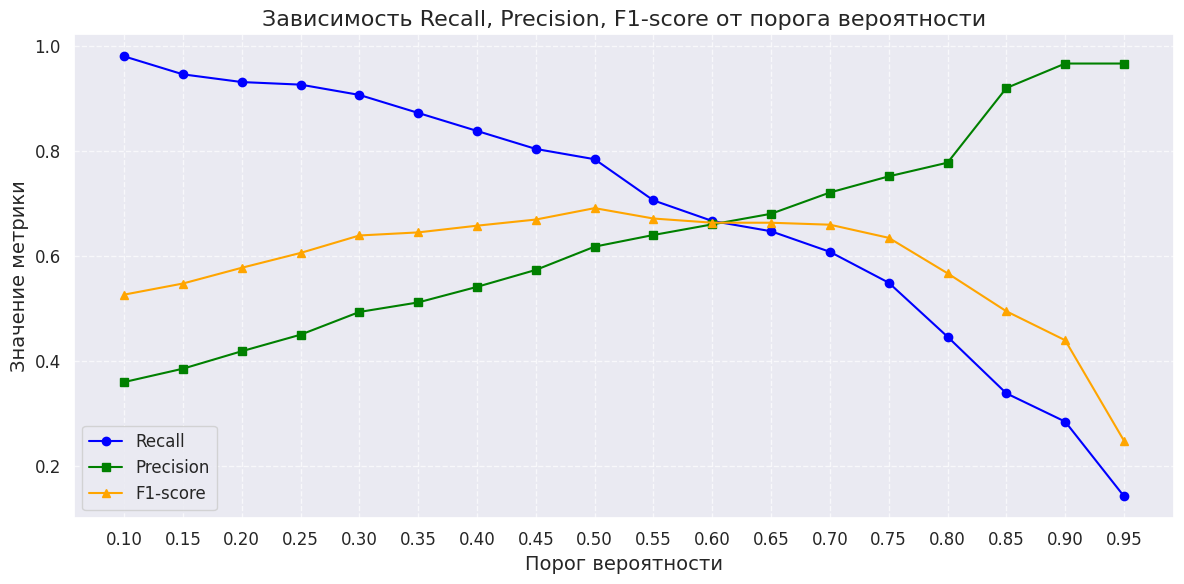

In [313]:
y_proba_pred = best_model_log_reg_poly.predict_proba(X_test_poly)[:, 1]
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred))


# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(12, 6))

# Строим графики для Recall, Precision и F1-score
ax.plot(thresholds, recall_scores, label='Recall', color='blue', linestyle='-', marker='o', markersize=6)
ax.plot(thresholds, precision_scores, label='Precision', color='green', linestyle='-', marker='s', markersize=6)
ax.plot(thresholds, f1_scores, label='F1-score', color='orange', linestyle='-', marker='^', markersize=6)

# Даём графику название и подписываем оси
ax.set_title('Зависимость Recall, Precision, F1-score от порога вероятности', fontsize=16)
ax.set_xlabel('Порог вероятности', fontsize=14)
ax.set_ylabel('Значение метрики', fontsize=14)

# Устанавливаем отметки по оси x
ax.set_xticks(thresholds)
# Устанавливаем размер шрифта для меток
ax.tick_params(axis='both', which='major', labelsize=12)
# Добавляем сетку для наглядности
ax.grid(True, linestyle='--', alpha=0.7)
# Отображаем легенду
ax.legend(loc='lower left', fontsize=12)

# Показать график
plt.tight_layout()
plt.show()

In [318]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.59
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# Рассчитываем F1-меру для тестовой выборки лучшей модели с новым порогом вероятности
print('F1 score с лучшими параметрами модели с полиноминальными признаками: {:.2f}'.format(metrics.f1_score(y_test, y_pred_opt)))

F1 score с лучшими параметрами модели с полиноминальными признаками: 0.67


F1 score имеет максимальное значение при пороге вероятности 0.5. Но recall и percision в этой точе различны. Поэтому выберем точку пересечения всех 3х линий.
Да F1 незначительно уменьшился, но зато мы достигнем баланса, что и требуется.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [319]:
X = df_final.drop("Exited", axis=1)
y = df_final["Exited"]

In [320]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y,
    stratify=y,
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 14)
Test shape: (628, 14)


Импортируем необходимые для выполнения практики модули:

In [321]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию.

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**):
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [322]:
#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = dt_clf.predict(X_train)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
#Делаем предсказание класса
y_pred_test = dt_clf.predict(X_test)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 1.00
F1 score: 0.55


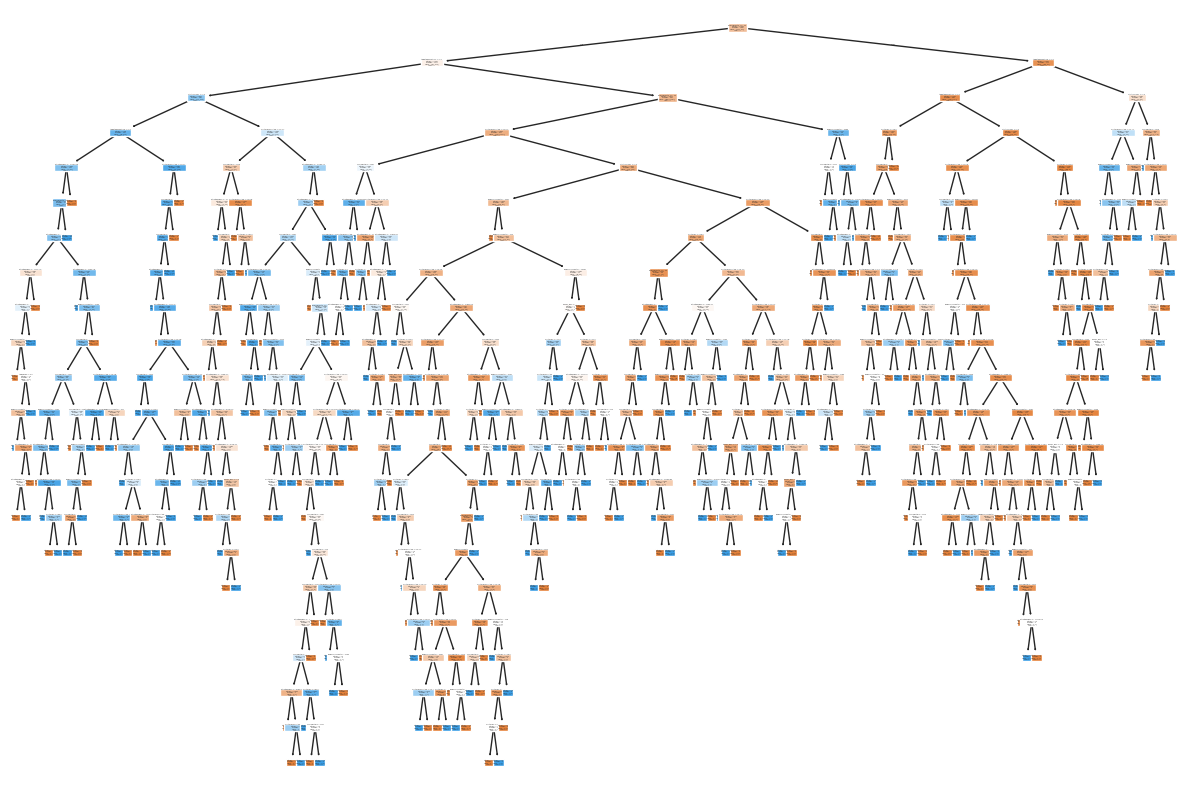

In [323]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф
tree_graph = tree.plot_tree(
    dt_clf, #объект обученного дерева
    feature_names=X_train.columns, #наименования факторов
    class_names=["0", "1"], #имена классов
    filled=True, #расцветка графа
);

In [324]:
dt_clf.get_depth()

21

> Без ограничения максимальной глубины дерева, наше дерево стало задавать слишком много вопросов, полностью подстроивщись под тренировочные данные.
Модель оказалась полностью переобученной.

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево.

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**):
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [326]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_new = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=8,#максимальная глубина
    min_samples_leaf=10, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел
)
#Обучаем модель
dt_clf_new.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = dt_clf_new.predict(X_train)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
#Делаем предсказание класса
y_pred_test = dt_clf_new.predict(X_test)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 0.71
F1 score: 0.57


> При данных параметрах модель остается немного переобученной. Необходимо провести кросс-валидацию для настройки оптимальных параметров.

In [328]:
max_depth = range(3,12)
min_samples_leaf = range(1,11)
for depth in max_depth:
  for leaf in min_samples_leaf:
    dt_clf_n = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=depth,
    min_samples_leaf=leaf,
    random_state=42
  )
    print(f'Параметры max_depth = {depth}, min_samples_leaf = {leaf}')
    # Обучаем модель
    dt_clf_n.fit(X_train, y_train)
    #Делаем предсказание класса
    y_pred_train = dt_clf_n.predict(X_train)
    #Рассчитываем F1-меру
    print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
    #Делаем предсказание класса
    y_pred_test = dt_clf_n.predict(X_test)
    #Рассчитываем F1-меру
    print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))
    print()

Параметры max_depth = 3, min_samples_leaf = 1
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 2
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 3
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 4
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 5
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 6
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 7
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 8
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 9
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 3, min_samples_leaf = 10
F1 score: 0.66
F1 score: 0.64

Параметры max_depth = 4, min_samples_leaf = 1
F1 score: 0.68
F1 score: 0.61

Параметры max_depth = 4, min_samples_leaf = 2
F1 score: 0.68
F1 score: 0.61

Параметры max_depth = 4, min_samples_leaf = 3
F1 score: 0.68
F1 score: 0.61

>
**Параметры max_depth = 3, min_samples_leaf = 1**

* F1 score: 0.66
* F1 score: 0.64

Удалось повысить незначительно метрику на тестовой выборке. Но на данной этапе у нас есть модель с более высокой метрикой. Поэтому не будем использовать эту модель

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом.

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**):
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [329]:
#Создаём объект класса RandomForestClassifier
rf_clf= ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
#Обучаем модель
rf_clf.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = rf_clf.predict(X_train)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
#Делаем предсказание класса
y_pred_test = rf_clf.predict(X_test)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 0.69
F1 score: 0.62


> При заданных параметрых метрику не удалось улучшить.
Посмотрим, что даст нам кросс валидация.

In [330]:
max_depth = range(3,12)
min_samples_leaf = range(1,12)

for depth in max_depth:
  for leaf in min_samples_leaf:

    rf_clf= ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=depth,
    min_samples_leaf=leaf,
    random_state=42
)
    print(f'Параметры max_depth = {depth}, min_samples_leaf = {leaf}')
    # Обучаем модель
    rf_clf.fit(X_train, y_train)
    #Делаем предсказание класса
    y_pred_train = rf_clf.predict(X_train)
    print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
    #Делаем предсказание класса
    y_pred_test = rf_clf.predict(X_test)
    print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))
    print()

Параметры max_depth = 3, min_samples_leaf = 1
F1 score: 0.63
F1 score: 0.57

Параметры max_depth = 3, min_samples_leaf = 2
F1 score: 0.63
F1 score: 0.57

Параметры max_depth = 3, min_samples_leaf = 3
F1 score: 0.63
F1 score: 0.57

Параметры max_depth = 3, min_samples_leaf = 4
F1 score: 0.63
F1 score: 0.56

Параметры max_depth = 3, min_samples_leaf = 5
F1 score: 0.63
F1 score: 0.56

Параметры max_depth = 3, min_samples_leaf = 6
F1 score: 0.62
F1 score: 0.56

Параметры max_depth = 3, min_samples_leaf = 7
F1 score: 0.62
F1 score: 0.56

Параметры max_depth = 3, min_samples_leaf = 8
F1 score: 0.62
F1 score: 0.57

Параметры max_depth = 3, min_samples_leaf = 9
F1 score: 0.62
F1 score: 0.57

Параметры max_depth = 3, min_samples_leaf = 10
F1 score: 0.62
F1 score: 0.56

Параметры max_depth = 3, min_samples_leaf = 11
F1 score: 0.62
F1 score: 0.56

Параметры max_depth = 4, min_samples_leaf = 1
F1 score: 0.68
F1 score: 0.60

Параметры max_depth = 4, min_samples_leaf = 2
F1 score: 0.68
F1 score: 0.6

In [331]:
#Создаём объект класса RandomForestClassifier
rf_clf_best = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=1,
    random_state=42
)
#Обучаем модель
rf_clf_best.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = rf_clf_best.predict(X_train)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
#Делаем предсказание класса
y_pred_test = rf_clf_best.predict(X_test)
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score: 0.74
F1 score: 0.64


> Что касается моделей дерева решений и случайного леса, то на наших данных они далее более низкие показатели метрики. Даже с подбором оптимальных параметров не удалось достичь показателей, которые были получены с помощью логистической регресси.
Обе модели дали одинаковые значения метрики на тестовых данных, но модель дерева решений была менее переобученная по сравнению со случайнм лесом.

### Задание 8.4. (2 балла)

Мы на финишной прямой.


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее.

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

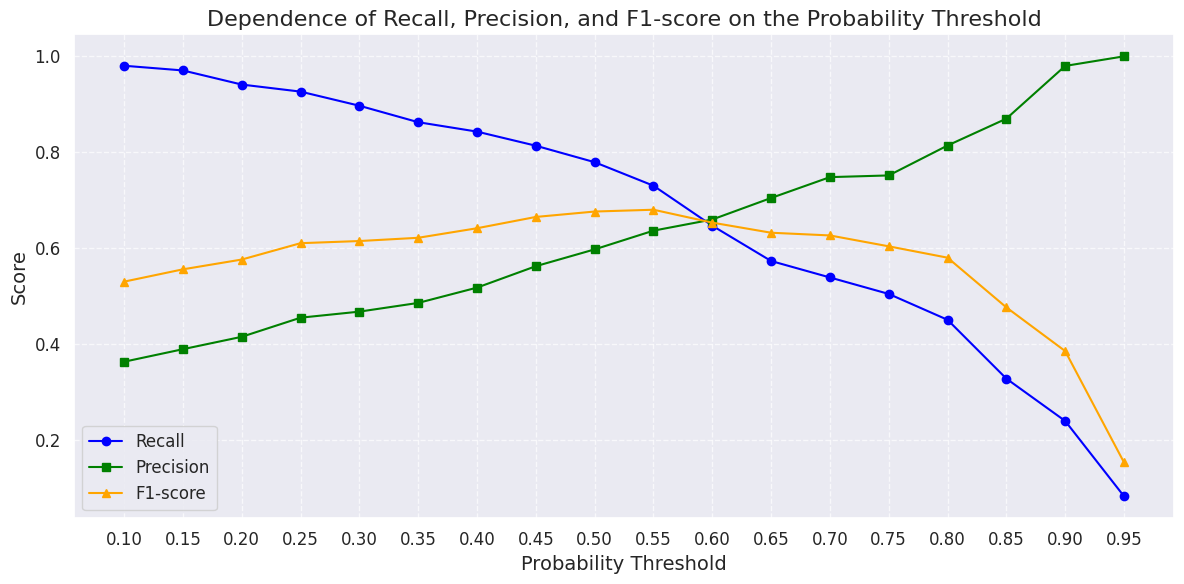

In [332]:
y_proba_pred = best_model_log_reg.predict_proba(X_test_scaled)[:, 1]
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred, zero_division=0))


# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(12, 6))

# Строим графики для Recall, Precision и F1-score
ax.plot(thresholds, recall_scores, label='Recall', color='blue', linestyle='-', marker='o', markersize=6)
ax.plot(thresholds, precision_scores, label='Precision', color='green', linestyle='-', marker='s', markersize=6)
ax.plot(thresholds, f1_scores, label='F1-score', color='orange', linestyle='-', marker='^', markersize=6)

# Даём графику название и подписываем оси
ax.set_title('Dependence of Recall, Precision, and F1-score on the Probability Threshold', fontsize=16)
ax.set_xlabel('Probability Threshold', fontsize=14)
ax.set_ylabel('Score', fontsize=14)

# Устанавливаем отметки по оси x
ax.set_xticks(thresholds)
# Устанавливаем размер шрифта для меток
ax.tick_params(axis='both', which='major', labelsize=12)
# Добавляем сетку для наглядности
ax.grid(True, linestyle='--', alpha=0.7)
# Отображаем легенду
ax.legend(loc='lower left', fontsize=12)

# Показать график
plt.tight_layout()
plt.show()

In [334]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.57
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# Рассчитываем F1-меру для тестовой выборки лучшей модели с новым порогом вероятности
print('F1 score с лучшей моделью: {:.2f}'.format(metrics.f1_score(y_test, y_pred_opt)))

F1 score с лучшей моделью: 0.67


> Даже не смотря на то, что показатель метрики после выбора нового порога вероятности уменьшился была получена достаточно хорошая модель.
Более точной я считаю модель логистичской регресси с полиномиаьными признаками второй степени. Там метрика достигла такого же значения именно в персечении всех 3х метрик.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки;
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**):
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [335]:
new_client = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

# Создание новых признаков
new_client['BalanceSalaryRatio'] = new_client['Balance'] / new_client['EstimatedSalary']
new_client['TenureByAge'] = new_client['Tenure'] / new_client['Age']
new_client['CreditScoreGivenAge'] = new_client['CreditScore'] / new_client['Age']
new_client['AgeBetween18And41'] = (new_client['Age'] <= 41).astype('int')
new_client['AgeBetween42And47']= ((new_client['Age'] > 41) & (new_client['Age'] <= 47)).astype('int')
new_client['AgeBetween48And65']= ((new_client['Age'] > 47) & (new_client['Age'] <= 65)).astype('int')
new_client['AgeMore65'] = (new_client['Age'] > 65).astype('int')
new_client['Gender_Male'] = (new_client['Gender'] == 'Male').astype('int')
new_client['NumOfProducts_2'] = (new_client['NumOfProducts'] == 2.0).astype('int')
new_client['NumOfProducts_3'] = (new_client['NumOfProducts'] == 3.0).astype('int')
new_client['NumOfProducts_4'] = (new_client['NumOfProducts'] == 4.0).astype('int')
new_client[columns_to_scale] = scaler.transform(new_client[columns_to_scale])

y_proba_pred = best_model_log_reg.predict_proba(new_client[X_train.columns])[:, 1]
y_proba = best_model_log_reg.predict(new_client[X_train.columns])

In [336]:
print(f'Вероятность того, что клиент перестанет быть лояльным - {y_proba_pred}')
print(f'Прогнозируемый класс Exited нового клиента = {y_proba}')

Вероятность того, что клиент перестанет быть лояльным - [0.78823355]
Прогнозируемый класс Exited нового клиента = [1]


# Посмотрим на предсказание логистической регресии с полиномиальными признаками.

In [340]:
new_client = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

# Создание новых признаков
new_client['BalanceSalaryRatio'] = new_client['Balance'] / new_client['EstimatedSalary']
new_client['TenureByAge'] = new_client['Tenure'] / new_client['Age']
new_client['CreditScoreGivenAge'] = new_client['CreditScore'] / new_client['Age']
new_client['AgeBetween18And41'] = (new_client['Age'] <= 41).astype('int')
new_client['AgeBetween42And47']= ((new_client['Age'] > 41) & (new_client['Age'] <= 47)).astype('int')
new_client['AgeBetween48And65']= ((new_client['Age'] > 47) & (new_client['Age'] <= 65)).astype('int')
new_client['AgeMore65'] = (new_client['Age'] > 65).astype('int')
new_client['Gender_Male'] = (new_client['Gender'] == 'Male').astype('int')
new_client['NumOfProducts_2'] = (new_client['NumOfProducts'] == 2.0).astype('int')
new_client['NumOfProducts_3'] = (new_client['NumOfProducts'] == 3.0).astype('int')
new_client['NumOfProducts_4'] = (new_client['NumOfProducts'] == 4.0).astype('int')
new_client[columns_to_scale] = scaler.transform(new_client[columns_to_scale])
new_client = poly.transform(new_client[X_train.columns])



y_proba_pred = best_model_log_reg_poly.predict_proba(new_client)[:, 1]
y_proba = best_model_log_reg_poly.predict(new_client)

In [341]:
print(f'Вероятность того, что клиент перестанет быть лояльным - {y_proba_pred}')
print(f'Прогнозируемый класс Exited нового клиента = {y_proba}')

Вероятность того, что клиент перестанет быть лояльным - [0.8235577]
Прогнозируемый класс Exited нового клиента = [1]


**Для более точного результата итоговую вероятность ухода клиента можно получить путем объединения результатов обеих моделей. Самый простой вариант взять среднее от 2х вероятностей (0.8058956)*

# Подведем итог
При обучении на таких признаках:

*Исходные:*
1. 'CreditScore'
2. 'Age'
3. 'Balance'
4. 'HasCrCard'
2. 'IsActiveMember'
3. 'EstimatedSalary'

*Новые признаки:*
1. 'BalanceSalaryRatio'
2. 'TenureByAge'
3. 'CreditScoreGivenAge'
4. 'Gender_Male'

**Логистическая регрессия дала:**
* F1 score: 0.52 тренировочные данные
* F1 score: 0.50 тестовые данные

После подбора оптимальных параметров(C = 0.1, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')

F1 score с лучшей моделью: 0.60
F1 score с лучшей моделью: 0.58

**С полиномиальными признаками третьей степени:**
* F1 score: 0.51 тренировочные данные
* F1 score: 0.48 тестовые данные

**С полиномиальными признаками второй степени:**
* F1 score: 0.51 тренировочные данные
* F1 score: 0.49 тестовые данные

После подбора оптимальных параметров(C = 10, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear')
* F1 score: 0.69 тренировочные данные
* F1 score: 0.69 тестовые данные

После выбора оптимального порога вероятности 0.6, F1 scorе стала на уровне 0.66. Максимальный скор наблюдается при пороге в 0.5

**Дерево решений**
* F1 score: 1.00 тренировочные данные
* F1 score: 0.54 тестовые данные

С параметрами max_depth = 8, min_samples_leaf = 10

* F1 score: 0.72 тренировочные данные
* F1 score: 0.66 тестовые данные

С подбором оптимальных параметров (max_depth = 11, min_samples_leaf = 9):
* F1 score: 0.78 тренировочные данные
* F1 score: 0.66 тестовые данные

**Случайный лес**

Параметры(n_esminators = 500, max_depth = 8, min_samples_leaf = 10)
* F1 score: 0.74 тренировочные данные
* F1 score: 0.64 тестовые данные

После подбора оптимальных параметров(n_esminators = 500, max_depth = 6, min_samples_leaf = 10)
* F1 score: 0.70
* F1 score: 0.67

Попробуем сместить порог вероятности (0.4) для случайного леса F1 score стал равен 0.69

**Итоговое предсказание**
Вероятность того, что клиент перестанет быть лояльным - [0.5716376]
Прогнозируемый класс Exited нового клиента = [1]

**При данных признаках лучшими моделью стал случайный лес с порогом вероятности 0.4**


При обучении на таких признаках:

*Исходные:*
1. 'CreditScore'
2. 'IsActiveMember'
3. 'EstimatedSalary'

*Новые признаки:*
1. 'BalanceSalaryRatio'
2. 'TenureByAge'
3. 'CreditScoreGivenAge'
4. 'Gender_Male'
5. 'NumOfProducts_2'
6. 'NumOfProducts_3'
7. 'NumOfProducts_4'
8. 'AgeBetween18And41'
9. 'AgeBetween42And47'
10. 'AgeBetween48And65'
11. 'AgeMore65'

**Логистическая регрессия дала:**
* F1 score: 0.66 тренировочные данные
* F1 score: 0.63 тестовые данные

После подбора оптимальных параметров(C = 1, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')

F1 score с лучшей моделью: 0.68
F1 score с лучшей моделью: 0.68

**С полиномиальными признаками третьей степени:**
* F1 score: 0.72 тренировочные данные
* F1 score: 0.64 тестовые данные

**С полиномиальными признаками второй степени:**
* F1 score: 0.68 тренировочные данные
* F1 score: 0.65 тестовые данные

После подбора оптимальных параметров(C = 10, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear')
* F1 score: 0.69 тренировочные данные
* F1 score: 0.69 тестовые данные

После выбора оптимального порога вероятности 0.6, F1 score также стала на уровне 0.66. Максимальный скор наблюдается при пороге в 0.5

**Дерево решений**
* F1 score: 1.00 тренировочные данные
* F1 score: 0.54 тестовые данные

С параметрами max_depth = 8, min_samples_leaf = 10

* F1 score: 0.72 тренировочные данные
* F1 score: 0.57 тестовые данные

С подбором оптимальных параметров (max_depth = 3, min_samples_leaf = 1):
* F1 score: 0.66 тренировочные данные
* F1 score: 0.64 тестовые данные

**Случайный лес**

Параметры(n_esminators = 500, max_depth = 8, min_samples_leaf = 10)
* F1 score: 0.69 тренировочные данные
* F1 score: 0.62 тестовые данные

После подбора оптимальных параметров(n_esminators = 500, max_depth = 8, min_samples_leaf = 1)
* F1 score: 0.74
* F1 score: 0.64

Попробуем сместить порог вероятности (0.57) для логистической регрессии без полиномиальных признаков F1 score стал равен 0.67

**Итоговое предсказание**

Логистическая регрессия

Вероятность того, что клиент перестанет быть лояльным - [0.78823355]
Прогнозируемый класс Exited нового клиента = [1]

Логистическая регрессия с полиномиальными признаками

Вероятность того, что клиент перестанет быть лояльным - [0.8235577]
Прогнозируемый класс Exited нового клиента = [1]

**При данных признаках лучшими моделями стали логистическая регрессия и логистическая регрессия с полиномиальными признаками. Обе эти модели дали самые высокие значения F1 score, а также обе модели предсказали то, что клиент скорее всего откажется от услуг банка**
